In [1]:
import os
import glob
import xml.etree.ElementTree as ET
import pandas as pd
import tensorflow as tf

In [2]:
%mkdir TF2
%cd TF2
%mkdir training
%mkdir data
%cd data

/content/TF2
/content/TF2/data


In [3]:
%pwd

'/content/TF2/data'

In [4]:
%cd /content/

/content


In [5]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
! mkdir ~/.kaggle

In [7]:
! cp kaggle.json ~/.kaggle/

In [8]:
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
%mkdir Kaggle_Data
%cd Kaggle_Data

/content/Kaggle_Data


In [10]:
! kaggle datasets download techzizou/labeled-mask-dataset-pascal-voc-format

 81% 87.0M/108M [00:00<00:00, 318MB/s]
100% 108M/108M [00:00<00:00, 310MB/s] 


In [ ]:
!unzip labeled-mask-dataset-pascal-voc-format.zip

In [12]:
%cd /content/

/content


In [13]:
!git clone --q https://github.com/tensorflow/models.git

In [14]:
%cd /content/models/research

/content/models/research


In [15]:
!protoc object_detection/protos/*.proto --python_out=.

In [16]:
!cp object_detection/packages/tf2/setup.py .
!python -m pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 10.3 MB 55.2 MB/s 
     |████████████████████████████████| 352 kB 60.1 MB/s 
     |████████████████████████████████| 2.1 MB 47.3 MB/s 
     | 665.5 MB 412 kB/s
     |████████████████████████████████| 1.8 MB 45.9 MB/s 
     |████████████████████████████████| 23.1 MB 1.2 MB/s 
     |████████████████████████████████| 67 kB 7.3 MB/s 
     |████████████████████████████████| 1.3 MB 59.8 MB/s 
     |████████████████████████████████|

In [17]:
!python object_detection/builders/model_builder_tf2_test.py

Running tests under Python 3.7.13: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
2022-06-26 11:51:49.904832: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
W0626 11:51:50.117489 140678194153344 model_builder.py:1102] Building experimental DeepMAC meta-arch. Some features may be omitted.
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 1.35s
I0626 11:51:50.464499 140678194153344 test_util.py:2309] time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 1.35s
[       OK ] ModelBuilderTF2Test.test_create_center_net_deepmac
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_model0 (customize_head_params=True)): 0.49s
I0626 11:51:50.956436 140678194153344 test

In [19]:
%cd /content/TF2/data

/content/TF2/data


In [20]:
!mkdir test_labels train_labels

In [21]:
!ls annotations/* | sort -R | head -274 | xargs -I{} mv {} test_labels/

!ls annotations/* | xargs -I{} mv {} train_labels/

In [22]:
def xml_to_csv(path):
  classes_names = []
  xml_list = []

  for xml_file in glob.glob(path + '/*.xml'):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    for member in root.findall('object'):
      classes_names.append(member[0].text)
      value = (root.find('filename').text  ,   
               int(root.find('size')[0].text),
               int(root.find('size')[1].text),
               member[0].text,
               int(member[4][0].text),
               int(member[4][1].text),
               int(member[4][2].text),
               int(member[4][3].text))
      xml_list.append(value)
  column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
  xml_df = pd.DataFrame(xml_list, columns=column_name) 
  classes_names = list(set(classes_names))
  classes_names.sort()
  return xml_df, classes_names

for label_path in ['train_labels', 'test_labels']:
  image_path = os.path.join(os.getcwd(), label_path)
  xml_df, classes = xml_to_csv(label_path)
  xml_df.to_csv(f'{label_path}.csv', index=None)
  print(f'Successfully converted {label_path} xml to csv.')

label_map_path = os.path.join("label_map.pbtxt")
pbtxt_content = ""

for i, class_name in enumerate(classes):
    pbtxt_content = (
        pbtxt_content
        + "item {{\n    id: {0}\n    name: '{1}'\n}}\n\n".format(i + 1, class_name)
    )
pbtxt_content = pbtxt_content.strip()
with open(label_map_path, "w") as f:
    f.write(pbtxt_content)
    print('Successfully created label_map.pbtxt ')

Successfully converted train_labels xml to csv.
Successfully converted test_labels xml to csv.
Successfully created label_map.pbtxt 


In [23]:
#For train.record
!python /content/TF2/generate_tfrecord.py train_labels.csv  label_map.pbtxt images/ train.record

#For test.record
!python /content/TF2/generate_tfrecord.py test_labels.csv  label_map.pbtxt images/ test.record

groups: 100% 1096/1096 [00:01<00:00, 780.49it/s]
Successfully created the TFRecords: /content/TF2/data/train.record
groups: 100% 274/274 [00:00<00:00, 961.81it/s]
Successfully created the TFRecords: /content/TF2/data/test.record


In [24]:
!pwd

/content/TF2/data


In [25]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz

--2022-06-26 11:58:20--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.2.112, 2607:f8b0:4004:832::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.2.112|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46042990 (44M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_32 100%[===================>]  43.91M   224MB/s    in 0.2s    

2022-06-26 11:58:21 (224 MB/s) - ‘ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz’ saved [46042990/46042990]



In [26]:
!tar -xzvf ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz

ssd_mobilenet_v2_320x320_coco17_tpu-8/
ssd_mobilenet_v2_320x320_coco17_tpu-8/checkpoint/
ssd_mobilenet_v2_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
ssd_mobilenet_v2_320x320_coco17_tpu-8/checkpoint/checkpoint
ssd_mobilenet_v2_320x320_coco17_tpu-8/checkpoint/ckpt-0.index
ssd_mobilenet_v2_320x320_coco17_tpu-8/pipeline.config
ssd_mobilenet_v2_320x320_coco17_tpu-8/saved_model/
ssd_mobilenet_v2_320x320_coco17_tpu-8/saved_model/saved_model.pb
ssd_mobilenet_v2_320x320_coco17_tpu-8/saved_model/variables/
ssd_mobilenet_v2_320x320_coco17_tpu-8/saved_model/variables/variables.data-00000-of-00001
ssd_mobilenet_v2_320x320_coco17_tpu-8/saved_model/variables/variables.index


In [27]:
%cd /content/models/research/object_detection

/content/models/research/object_detection


In [30]:
!pip install opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67.1 MB 38 kB/s 


In [31]:
!python model_main_tf2.py --pipeline_config_path=/content/ssd_mobilenet_v2_320x320_coco17_tpu-8.config --model_dir=/content/TF2/training

2022-06-26 12:03:58.632351: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
I0626 12:03:58.635578 140461051803520 mirrored_strategy.py:376] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: None
I0626 12:03:58.639589 140461051803520 config_util.py:552] Maybe overwriting train_steps: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0626 12:03:58.639734 140461051803520 config_util.py:552] Maybe overwriting use_bfloat16: False
Instructions for updating:
rename to distribute_datasets_from_function
W0626 12:03:58.793113 140461051803520 deprecation.py:347] From /usr/local/lib/python3.7/dist-packages/object_detection/model_lib_v2.py:564: StrategyBase.experiment

In [32]:
!python exporter_main_v2.py --trained_checkpoint_dir=/content/TF2/training --pipeline_config_path=/content/ssd_mobilenet_v2_320x320_coco17_tpu-8.config --output_directory /content/TF2/data/inference_graph

2022-06-26 12:41:09.900136: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
W0626 12:41:10.057909 140246620047232 deprecation.py:619] From /usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:464: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with back_prop=False is deprecated and will be removed in a future version.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
INFO:tensorflow:depth of addition

Loading model...Done!


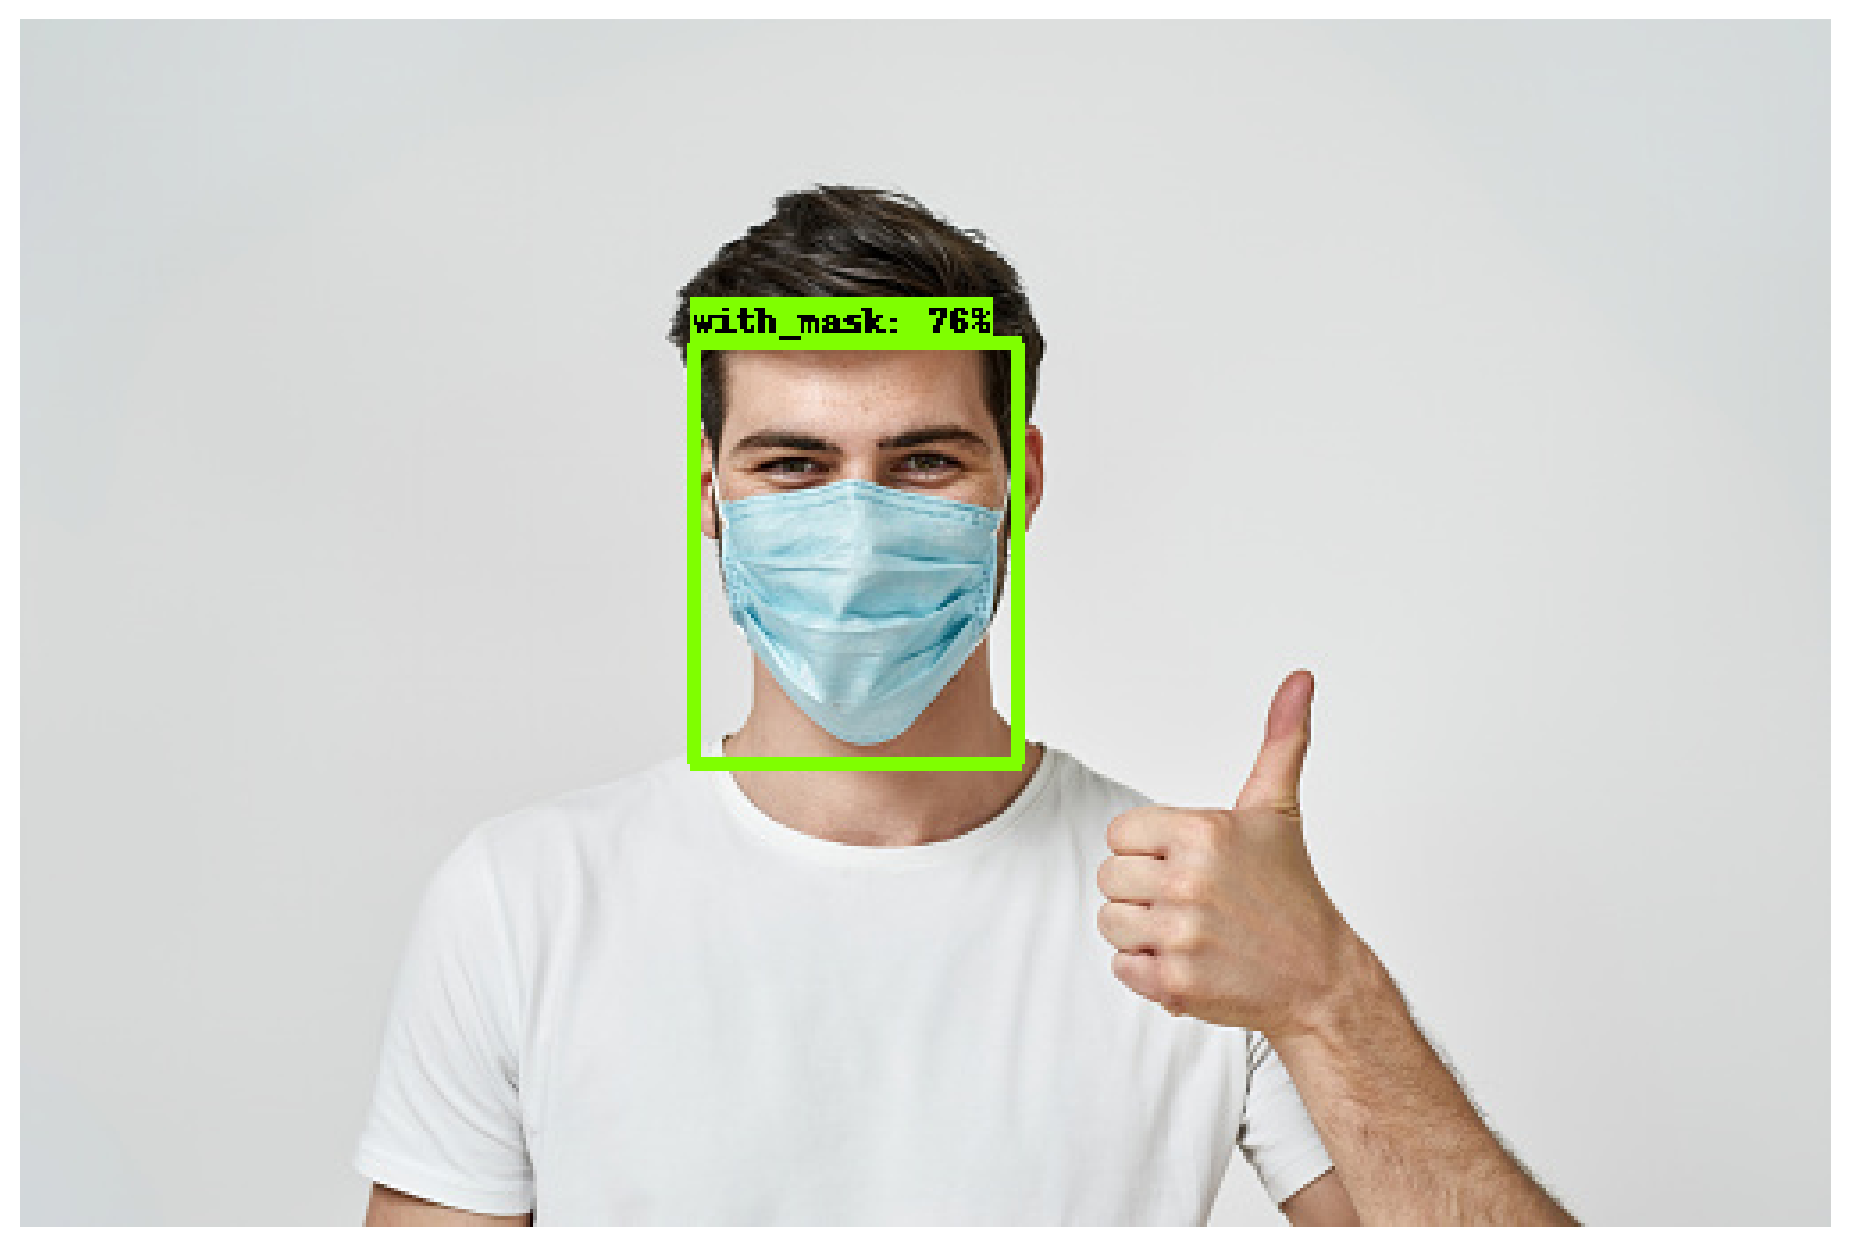

In [33]:
#Loading the saved_model
import tensorflow as tf
import time
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
from google.colab.patches import cv2_imshow
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

IMAGE_SIZE = (12, 8) # Output display size as you want
import matplotlib.pyplot as plt
PATH_TO_SAVED_MODEL="/content/TF2/data/inference_graph/saved_model"
print('Loading model...', end='')

detect_fn=tf.saved_model.load(PATH_TO_SAVED_MODEL)
print('Done!')

category_index=label_map_util.create_category_index_from_labelmap("/content/TF2/data/label_map.pbtxt",use_display_name=True)

def load_image_into_numpy_array(path):

    return np.array(Image.open(path))

image_path = "/content/1.jpg"

image_np = load_image_into_numpy_array(image_path)

input_tensor = tf.convert_to_tensor(image_np)
input_tensor = input_tensor[tf.newaxis, ...]

detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'],
      detections['detection_classes'],
      detections['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.4, # Adjust this value to set the minimum probability boxes to be classified as True
      agnostic_mode=False)
%matplotlib inline
plt.figure(figsize=IMAGE_SIZE, dpi=200)
plt.axis("off")
plt.imshow(image_np_with_detections)
plt.show()